In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

DATA_PATH = "../donnees/ecommerce/"

In [12]:
# Chargement du parquet F_ACHATS créé dans l'analyse 1
F_ACHATS = pd.read_parquet("f_achats.parquet")

print("F_ACHATS chargé depuis f_achats.parquet")
print("Shape :", F_ACHATS.shape)
print("Colonnes :", list(F_ACHATS.columns))
display(F_ACHATS.head(3))

F_ACHATS chargé depuis f_achats.parquet
Shape : (112650, 13)
Colonnes : ['order_item_id', 'order_id', 'product_id', 'seller_id', 'customer_id', 'zip_code', 'purchase_timestamp', 'order_status', 'price', 'freight_value', 'line_revenue', 'line_total', 'limit']


,order_item_id,order_id,product_id,seller_id,customer_id,zip_code,purchase_timestamp,order_status,price,freight_value,line_revenue,line_total,limit
0,1,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,3ce436f183e68e07877b285a838db11a,28013,2017-09-13 08:59:02,delivered,58.9,13.29,58.9,72.19,144.775833
1,1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,f6dd3ec061db4e3987629fe6b26e5cce,15775,2017-04-26 10:53:06,delivered,239.9,19.93,239.9,259.83,168.201944
2,1,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,6489ae5e4333f3693df5ad4372dab6d3,35661,2018-01-14 14:33:31,delivered,199.0,17.87,199.0,216.87,96.249722


In [13]:
# Recréation des dimensions de temps (locales, non sauvegardées dans le parquet)
F_ACHATS["year"]  = F_ACHATS["purchase_timestamp"].dt.year
F_ACHATS["month"] = F_ACHATS["purchase_timestamp"].dt.month
F_ACHATS["date"]  = F_ACHATS["purchase_timestamp"].dt.normalize()
F_ACHATS["week"]   = F_ACHATS["purchase_timestamp"].dt.isocalendar().week
F_ACHATS["weekday"] = F_ACHATS["purchase_timestamp"].dt.weekday
F_ACHATS["hour"]    = F_ACHATS["purchase_timestamp"].dt.hour

print("Colonnes temps ajoutées : year, month, date, week, weekday, hour")
display(
    F_ACHATS[["purchase_timestamp", "year", "month", "date", "week", "weekday", "hour"]]
    .head(3)
)

Colonnes temps ajoutées : year, month, date, week, weekday, hour


,purchase_timestamp,year,month,date,week,weekday,hour
0,2017-09-13 08:59:02,2017,9,2017-09-13,37,2,8
1,2017-04-26 10:53:06,2017,4,2017-04-26,17,2,10
2,2018-01-14 14:33:31,2018,1,2018-01-14,2,6,14


In [14]:
# Chargement des dimensions nécessaires pour l'analyse
products  = pd.read_parquet(DATA_PATH + "products.parquet")
customers = pd.read_parquet(DATA_PATH + "customers.parquet")

print("Dimensions chargées :")
print("products :", products.shape)
print("customers:", customers.shape)

# Préparation de la dimension produit
prod_dim = products[["product_id", "category_name"]].copy()

# Préparation de la dimension client avec macro-région
cust_dim = customers[["customer_id", "state", "name_state"]].copy()

region_map = {
    "SP": "Sudeste", "RJ": "Sudeste", "MG": "Sudeste", "ES": "Sudeste",
    "RS": "Sul", "SC": "Sul", "PR": "Sul",
    "BA": "Nordeste", "PE": "Nordeste", "CE": "Nordeste", "RN": "Nordeste",
    "PB": "Nordeste", "AL": "Nordeste", "SE": "Nordeste", "PI": "Nordeste",
    "MA": "Nordeste",
    "DF": "Centro-Oeste", "GO": "Centro-Oeste", "MT": "Centro-Oeste", "MS": "Centro-Oeste",
    "AM": "Norte", "PA": "Norte", "RO": "Norte", "RR": "Norte",
    "AP": "Norte", "TO": "Norte", "AC": "Norte"
}

cust_dim["macro_region"] = cust_dim["state"].map(region_map)

print("Dimensions produit et client préparées")

Dimensions chargées :
products : (32951, 9)
customers: (99441, 6)
Dimensions produit et client préparées


In [15]:
# Analyse 2 : Structure des paniers & pression logistique sur les segments clés
# Dans cette deuxième analyse sur l’étoile 2, on part des segments dominants
# identifiés dans l’analyse 1 (catégories phares et régions clés) et on regarde
# plus finement la structure des paniers : niveau de line_total, part du
# freight_value et contraintes de délai (limit). L’idée est de voir quels couples
# produit × région combinent à la fois fort volume, paniers élevés et poids
# logistique important, car ce sont eux qui risquent de poser le plus de problèmes
# opérationnels quand la demande explose.


In [16]:
# Hypothèse 2
# Puisqu’on a montré que le line_total est très concentré sur quelques catégories
# et sur la macro-région Sudeste, on suppose maintenant que ces mêmes segments
# présentent aussi les paniers les plus élevés et les coûts logistiques les plus forts.
# Autrement dit, les couples produit × région qui tirent le business sont aussi ceux
# où la pression logistique est maximale, ce qui en fait des zones critiques en cas
# de saturation et explique une partie des insatisfactions observées dans l’étoile 1.


In [17]:
# 1 Évolution annuelle du panier moyen et de la part logistique (line_total_mean vs freight_share)
# 2 Structure globale du panier : panier moyen et part logistique par catégorie de produit (Top 10)
# 3 Structure du panier et part logistique par macro-région client (Sudeste, Sul, Nordeste, etc.)
# 4 Heatmap panier moyen × part logistique par couple catégorie de produit × macro-région
# 5 Délai moyen limit (h) par catégorie de produit (Top 10) – pression temporelle par segment
# 6 Délai moyen limit (h) par macro-région et par état client – contraintes logistiques géographiques
# 7 Segments critiques : panier moyen, part logistique et délai moyen par couple catégorie × macro-région (Top 10)
# 8 Mois de pic : évolution quotidienne du panier moyen et de la part logistique (tous clients)
# 9 Mois de pic : comportement logistique des segments critiques (catégorie × macro-région) au jour le jour

In [18]:
# Enrichissement global de F_ACHATS (dimensions produit / client + délai en heures)

# Ajout de la catégorie produit
if "category_name" not in F_ACHATS.columns:
    F_ACHATS = F_ACHATS.merge(prod_dim, on="product_id", how="left")

# Ajout de la macro-région et de l'état client
if "macro_region" not in F_ACHATS.columns:
    cust_dim_renamed = cust_dim.rename(columns={"state": "cust_state", "name_state": "cust_name_state"})
    F_ACHATS = F_ACHATS.merge(cust_dim_renamed, on="customer_id", how="left")

# Recalcul / normalisation du délai limit en heures
if "limit_hours" not in F_ACHATS.columns:
    if np.issubdtype(F_ACHATS["limit"].dtype, np.number):
        F_ACHATS["limit_hours"] = F_ACHATS["limit"].astype(float)
    else:
        F_ACHATS["limit_hours"] = F_ACHATS["limit"].dt.total_seconds() / 3600

import calendar
sns.set_theme(style="whitegrid")


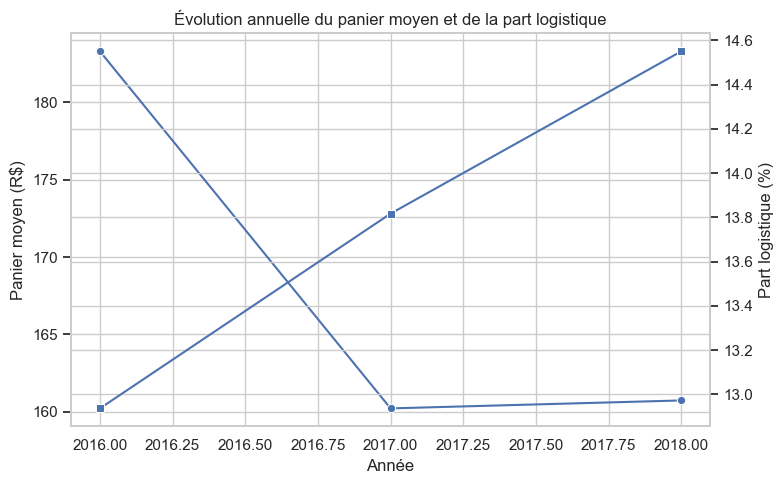

In [19]:
# 1 Évolution annuelle du panier moyen et de la part logistique (line_total_mean vs freight_share)

# Préparation
orders_year = (
    F_ACHATS
    .groupby(["order_id", "year"], as_index=False)
    .agg(
        basket_total=("line_total", "sum"),
        freight_total=("freight_value", "sum")
    )
)

annual = (
    orders_year
    .groupby("year", as_index=False)
    .agg(
        basket_mean=("basket_total", "mean"),
        basket_sum=("basket_total", "sum"),
        freight_sum=("freight_total", "sum")
    )
)
annual["freight_share"] = annual["freight_sum"] / annual["basket_sum"]

# Affichage
fig, ax1 = plt.subplots(figsize=(8, 5))

sns.lineplot(data=annual, x="year", y="basket_mean", marker="o", ax=ax1)
ax1.set_xlabel("Année")
ax1.set_ylabel("Panier moyen (R$)")
ax1.set_title("Évolution annuelle du panier moyen et de la part logistique")

ax2 = ax1.twinx()
sns.lineplot(data=annual, x="year", y=annual["freight_share"] * 100, marker="s", ax=ax2)
ax2.set_ylabel("Part logistique (%)")

plt.tight_layout()
plt.show()


In [ ]:
# On voit que le panier moyen par commande augmente nettement entre 2016 et 2018, en passant d’environ 160 R$ à plus de 180 R$.
# Cela signifie que, d’une année sur l’autre, les clients dépensent davantage à chaque commande, ce qui tire le chiffre d’affaires vers le haut.
# En parallèle, la part logistique (frais de livraison / montant du panier) diminue légèrement sur la même période.
# Elle passe d’un peu plus de 14,5 % à environ 13 %, ce qui indique que le poids relatif des coûts de livraison se réduit.
# Autrement dit, même si les frais absolus de livraison peuvent rester importants, ils représentent une part plus faible du panier global.
# Ce mouvement combiné (panier moyen en hausse, part logistique en baisse) va dans le sens d’une amélioration de la rentabilité par commande.
# On peut donc interpréter cette évolution comme un signe que la plateforme gagne en efficacité opérationnelle à mesure que le volume d’activité augmente.


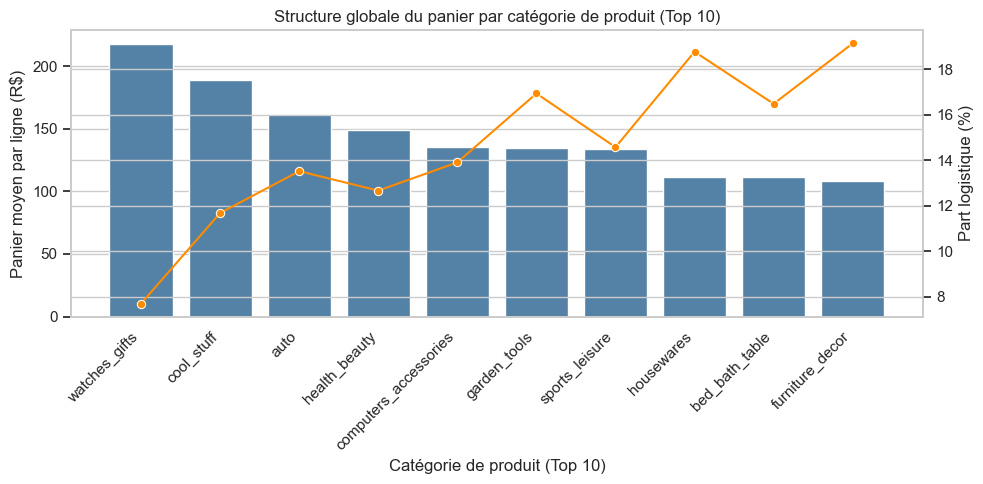

In [37]:
# 2 Structure globale du panier : panier moyen et part logistique par catégorie de produit (Top 10)

# Préparation
cat_metrics = (
    F_ACHATS
    .dropna(subset=["category_name"])
    .groupby("category_name", as_index=False)
    .agg(
        line_total_mean=("line_total", "mean"),
        line_total_sum=("line_total", "sum"),
        freight_sum=("freight_value", "sum")
    )
)
cat_metrics["freight_share"] = cat_metrics["freight_sum"] / cat_metrics["line_total_sum"]

top10_cat = (
    cat_metrics
    .sort_values("line_total_sum", ascending=False)
    .head(10)
    .sort_values("line_total_mean", ascending=False)
)
order = top10_cat["category_name"].tolist()

# Affichage
fig, ax1 = plt.subplots(figsize=(10, 5))

# barres dans une couleur claire
sns.barplot(
    data=top10_cat,
    x="category_name",
    y="line_total_mean",
    order=order,
    color="steelblue",
    ax=ax1
)
ax1.set_xlabel("Catégorie de produit (Top 10)")
ax1.set_ylabel("Panier moyen par ligne (R$)")
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

# courbe dans une couleur bien contrastée
ax2 = ax1.twinx()
sns.lineplot(
    data=top10_cat,
    x="category_name",
    y=top10_cat["freight_share"] * 100,
    marker="o",
    sort=False,
    color="darkorange",
    ax=ax2
)
ax2.set_ylabel("Part logistique (%)")

ax1.set_title("Structure globale du panier par catégorie de produit (Top 10)")
plt.tight_layout()
plt.show()


In [ ]:
# Ce graphique montre que les plus gros paniers moyens se trouvent sur les catégories “watches_gifts” et “cool_stuff”, nettement au-dessus des autres.
# Les segments “auto”, “health_beauty” et “computers_accessories” restent aussi dans le haut du classement, avec des paniers moyens autour de 150–170 R$.
# À l’inverse, des catégories plus “quotidiennes” comme “housewares”, “bed_bath_table” ou “furniture_decor” tournent autour de 110 R$, donc plus bas que la moyenne des Top 10.
# La courbe orange montre que la part logistique varie entre environ 8 % et 19 % selon la catégorie, ce qui n’est pas négligeable.
# Certaines catégories à panier élevé, comme “watches_gifts”, semblent absorber relativement bien les coûts de livraison (part logistique plutôt modérée).
# D’autres segments, comme “housewares” ou “furniture_decor”, combinent au contraire panier faible et part logistique élevée, ce qui fragilise leur performance unitaire.
# On ne peut pas calculer directement la marge avec ces données, mais on peut raisonnablement supposer que ces catégories “faibles panier / forte logistique” sont parmi les moins rentables.
# Globalement, ce graphique met en évidence quelques catégories “premium” qui combinent panier élevé et poids logistique raisonnable, et qui sont donc des cibles clés pour la rentabilité.


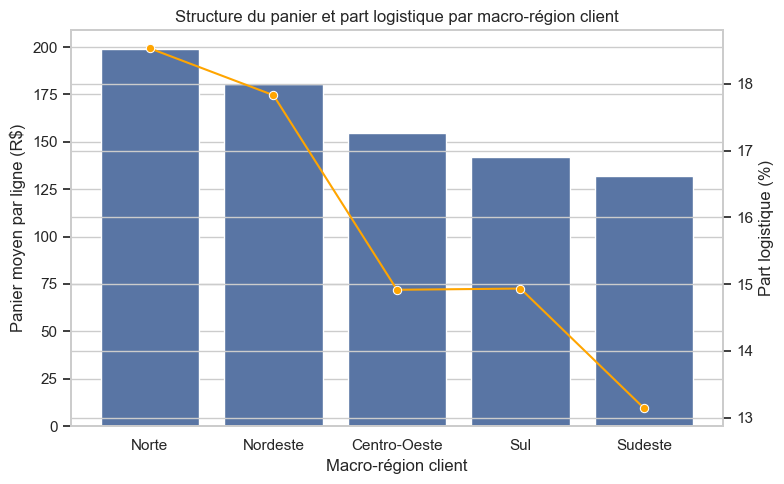

In [38]:
# 3 Structure du panier et part logistique par macro-région client (Sudeste, Sul, Nordeste, etc.)

# Préparation
macro_metrics = (
    F_ACHATS
    .dropna(subset=["macro_region"])
    .groupby("macro_region", as_index=False)
    .agg(
        line_total_mean=("line_total", "mean"),
        line_total_sum=("line_total", "sum"),
        freight_sum=("freight_value", "sum")
    )
)
macro_metrics["freight_share"] = macro_metrics["freight_sum"] / macro_metrics["line_total_sum"]
macro_metrics = macro_metrics.sort_values("line_total_mean", ascending=False)

# Affichage
fig, ax1 = plt.subplots(figsize=(8, 5))

sns.barplot(data=macro_metrics, x="macro_region", y="line_total_mean", ax=ax1)
ax1.set_xlabel("Macro-région client")
ax1.set_ylabel("Panier moyen par ligne (R$)")

ax2 = ax1.twinx()
sns.lineplot(
    data=macro_metrics,
    x="macro_region",
    y=macro_metrics["freight_share"] * 100,
    marker="o",
    color="orange",          # couleur plus visible
    ax=ax2
)
ax2.set_ylabel("Part logistique (%)")

ax1.set_title("Structure du panier et part logistique par macro-région client")
plt.tight_layout()
plt.show()


In [ ]:
# Ce graphique montre que le panier moyen par ligne est le plus élevé dans le Norte et le Nordeste, au-dessus de 175–190 R$, alors qu’il descend autour de 140–150 R$ dans le Sud et le Sudeste.
# Autrement dit, les clients des régions moins peuplées (Norte, Nordeste) dépensent plus par ligne lorsqu’ils commandent, alors que dans les zones plus denses les paniers sont un peu plus modestes.
# En parallèle, la courbe orange indique que la part logistique est justement la plus forte dans le Norte et le Nordeste, au-dessus de 18 %, et qu’elle baisse progressivement vers le Sud puis le Sudeste.
# La macro-région Sudeste se distingue par la combinaison “panier moyen le plus bas du graphe, mais part logistique minimale”, ce qui en fait la zone la plus efficace en termes de coûts de livraison relatifs.
# Dans les régions Norte et Nordeste, le surcoût logistique est clairement plus lourd : une part importante du panier part dans le transport, ce qui réduit la marge potentielle par vente.
# On retrouve ici une logique géographique intuitive : plus les clients sont éloignés des grands centres logistiques, plus la livraison pèse dans le business, même si le panier brut est attractif.
# Ces différences régionales suggèrent que la plateforme doit adapter sa stratégie : consolider les volumes dans le Sudeste pour la rentabilité, tout en optimisant la logistique dans le Norte et le Nordeste.


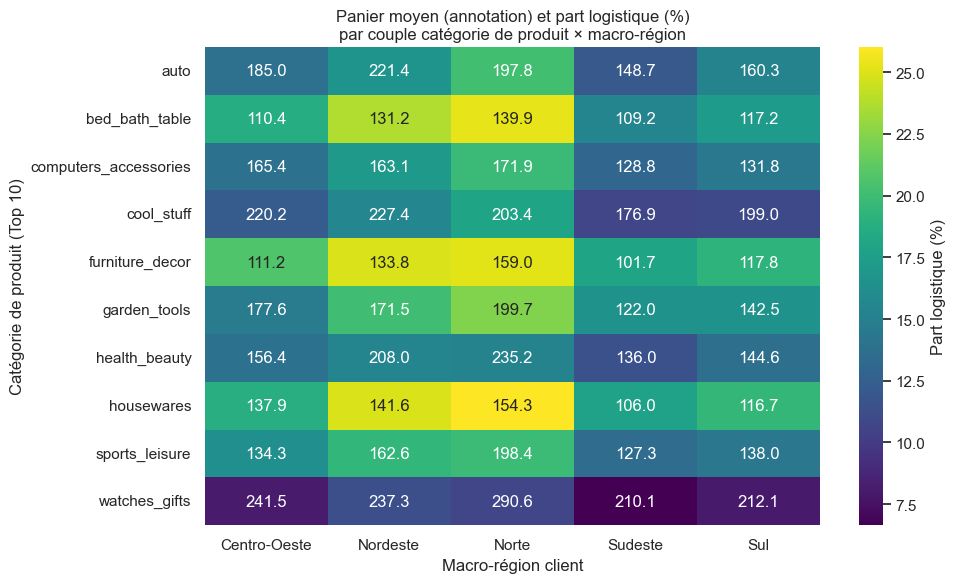

In [22]:
# 4 Heatmap panier moyen × part logistique par couple catégorie de produit × macro-région

# Préparation
seg = (
    F_ACHATS
    .dropna(subset=["category_name", "macro_region"])
    .groupby(["category_name", "macro_region"], as_index=False)
    .agg(
        line_total_mean=("line_total", "mean"),
        line_total_sum=("line_total", "sum"),
        freight_sum=("freight_value", "sum")
    )
)
seg["freight_share"] = seg["freight_sum"] / seg["line_total_sum"]

top_cat_for_heat = (
    seg.groupby("category_name")["line_total_sum"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

seg_top = seg[seg["category_name"].isin(top_cat_for_heat)]

pivot_freight = seg_top.pivot(
    index="category_name",
    columns="macro_region",
    values="freight_share"
)
pivot_basket = seg_top.pivot(
    index="category_name",
    columns="macro_region",
    values="line_total_mean"
)

# Affichage
fig, ax = plt.subplots(figsize=(10, 6))

sns.heatmap(
    pivot_freight * 100,
    annot=pivot_basket.round(1),
    fmt=".1f",
    cmap="viridis",
    cbar_kws={"label": "Part logistique (%)"},
    ax=ax
)

ax.set_xlabel("Macro-région client")
ax.set_ylabel("Catégorie de produit (Top 10)")
ax.set_title(
    "Panier moyen (annotation) et part logistique (%)\n"
    "par couple catégorie de produit × macro-région"
)
plt.tight_layout()
plt.show()


In [ ]:
# Cette heatmap permet de voir en même temps le panier moyen (chiffres dans les cases) et la part logistique (couleur) pour les 10 principales catégories selon la macro-région.
# On retrouve la bonne performance du Sudeste : pour beaucoup de catégories (auto, cool_stuff, watches_gifts), les paniers sont élevés alors que la part logistique reste parmi les plus basses.
# À l’inverse, le Nordeste se distingue par des couleurs plus “chaudes” sur plusieurs segments comme furniture_decor, housewares ou bed_bath_table, signe de frais de livraison très lourds.
# Le Norte combine parfois panier élevé et part logistique élevée, par exemple sur watches_gifts ou garden_tools, ce qui peut rogner fortement la marge sur ces segments éloignés.
# Certaines catégories volumineuses ou peu chères, comme furniture_decor et housewares, sont pénalisées dès qu’on sort du Sudeste, avec une part logistique qui dépasse fréquemment 20 %.
# Les catégories plus “premium” comme cool_stuff et watches_gifts résistent mieux : leurs paniers restent hauts dans toutes les régions, ce qui amortit mieux le coût de livraison.
# Globalement, ce graphique confirme que la rentabilité d’une catégorie dépend autant de la région servie que du niveau de panier lui-même, et que Nordeste / Norte concentrent les couples les plus critiques.


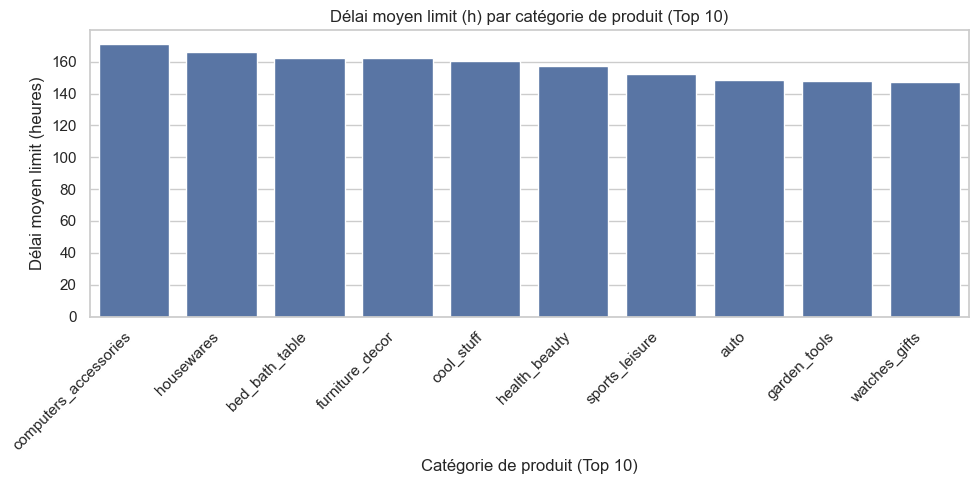

In [29]:
# 5 Délai moyen limit (h) par catégorie de produit (Top 10) – pression temporelle par segment

# Préparation
cat_delay = (
    F_ACHATS
    .dropna(subset=["category_name"])
    .groupby("category_name", as_index=False)
    .agg(
        limit_mean=("limit_hours", "mean"),
        line_total_sum=("line_total", "sum")
    )
)

top10_delay_cat = (
    cat_delay
    .sort_values("line_total_sum", ascending=False)
    .head(10)
    .sort_values("limit_mean", ascending=False)
)

# Affichage
fig, ax = plt.subplots(figsize=(10, 5))

sns.barplot(data=top10_delay_cat, x="category_name", y="limit_mean", ax=ax)
ax.set_xlabel("Catégorie de produit (Top 10)")
ax.set_ylabel("Délai moyen limit (heures)")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_title("Délai moyen limit (h) par catégorie de produit (Top 10)")

plt.tight_layout()
plt.show()


In [ ]:
# On voit que les délais moyens “limit” tournent tous autour de 150 à 170 heures, soit environ 6 à 7 jours entre la commande et la date limite d’expédition.
# La catégorie “computers_accessories” se situe en haut du classement, avec le délai moyen le plus long, ce qui confirme un traitement logistique plus complexe ou des stocks plus dispersés.
# Des segments volumineux comme “housewares”, “bed_bath_table” et “furniture_decor” restent eux aussi dans le haut de la fourchette, avec des délais proches de 160 heures.
# À l’inverse, des catégories comme “watches_gifts”, “garden_tools” ou “auto” bénéficient de délais légèrement plus courts, ce qui laisse penser à des chaînes d’approvisionnement plus efficaces ou mieux industrialisées.
# Même si les écarts restent relativement modestes, on voit que les catégories “maison / déco” supportent une pression temporelle plus forte, avec moins de marge pour absorber des retards supplémentaires.
# Pour les segments critiques identifiés plus tôt (fort volume, panier élevé), ces différences de quelques dizaines d’heures peuvent peser lourd en période de pic, en augmentant le risque de dépassement de SLA.
# Ce graphique suggère donc qu’un travail d’optimisation spécifique sur les catégories à délai long (notamment high-tech et maison) pourrait réduire la tension logistique lors des périodes de forte demande.

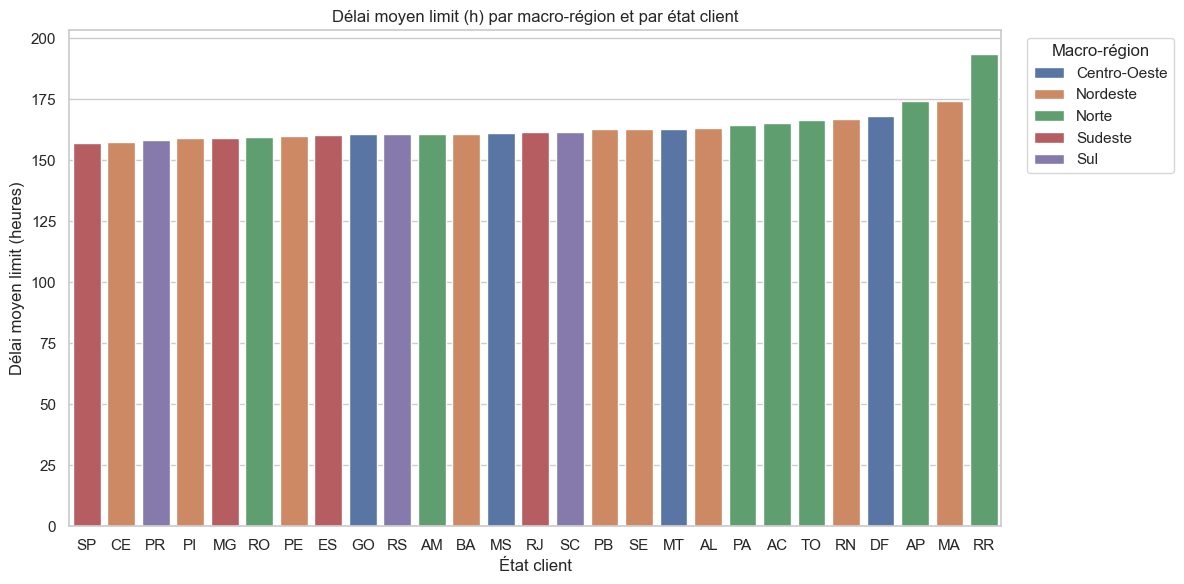

In [24]:
# 6 Délai moyen limit (h) par macro-région et par état client – contraintes logistiques géographiques

# Préparation
state_delay = (
    F_ACHATS
    .dropna(subset=["macro_region", "cust_state"])
    .groupby(["macro_region", "cust_state"], as_index=False)
    .agg(
        limit_mean=("limit_hours", "mean"),
        line_total_sum=("line_total", "sum")
    )
)

# Pour un ordre d'affichage cohérent des états
state_order = (
    state_delay
    .groupby("cust_state")["limit_mean"]
    .mean()
    .sort_values()
    .index
)

# Affichage
fig, ax = plt.subplots(figsize=(12, 6))

sns.barplot(
    data=state_delay,
    x="cust_state",
    y="limit_mean",
    hue="macro_region",
    order=state_order,
    ax=ax
)

ax.set_xlabel("État client")
ax.set_ylabel("Délai moyen limit (heures)")
ax.set_title("Délai moyen limit (h) par macro-région et par état client")
ax.legend(title="Macro-région", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()


In [ ]:
# Ce graphique montre que les délais moyens “limit” sont assez homogènes entre les États, le plus souvent autour de 155–165 heures, soit environ 6 à 7 jours.  
# Les États du Sudeste (SP, RJ, MG, ES) et du Sul (PR, RS, SC) se situent plutôt dans le bas de la fourchette, ce qui confirme une logistique globalement plus efficace dans ces régions denses.  
# La plupart des États du Nordeste (BA, PE, CE, PB, RN, etc.) présentent des délais légèrement plus élevés, mais sans rupture brutale : on reste généralement sous les 170 heures.  
# Les États du Norte (AM, PA, AC, RO, AP, RR) se distinguent davantage, avec plusieurs barres au-dessus de 170 heures et un maximum sur RR proche de 190 heures.  
# On observe aussi que le District fédéral (DF) se place dans le haut du tableau, ce qui peut traduire une chaîne logistique moins optimisée vers Brasilia malgré son statut de capitale.  
# Globalement, les écarts de délai restent bien plus faibles que les écarts de part logistique observés sur les graphiques précédents : la plateforme semble aligner ses SLA de préparation, mais au prix de coûts plus élevés dans les régions éloignées.  
# Cette lecture renforce l’idée que le vrai différentiel entre régions porte davantage sur le “coût” de la logistique que sur la “vitesse” pure de préparation des commandes.


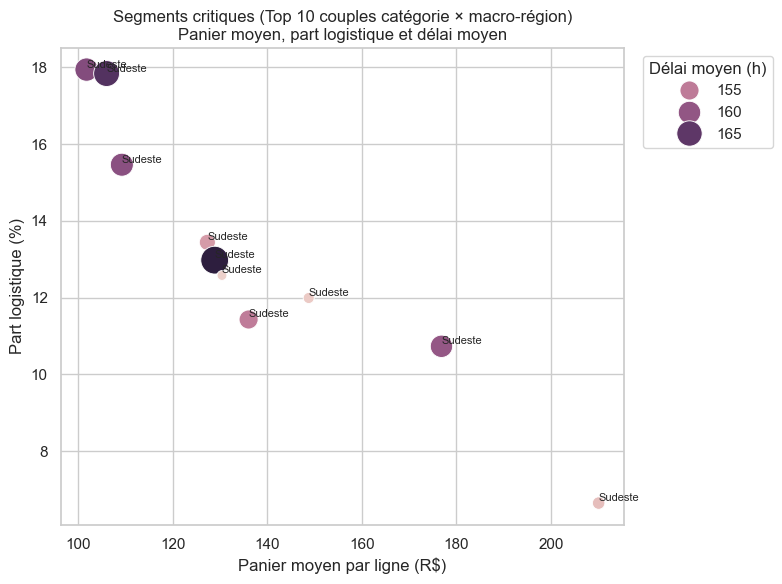

In [25]:
# 7 Segments critiques : panier moyen, part logistique et délai moyen par couple catégorie × macro-région (Top 10)

# Préparation
seg_full = (
    F_ACHATS
    .dropna(subset=["category_name", "macro_region"])
    .groupby(["category_name", "macro_region"], as_index=False)
    .agg(
        line_total_mean=("line_total", "mean"),
        line_total_sum=("line_total", "sum"),
        freight_sum=("freight_value", "sum"),
        limit_mean=("limit_hours", "mean")
    )
)
seg_full["freight_share"] = seg_full["freight_sum"] / seg_full["line_total_sum"]

top_segments = (
    seg_full
    .sort_values("line_total_sum", ascending=False)
    .head(10)
)

top_segments["segment"] = (
    top_segments["category_name"] + " / " + top_segments["macro_region"]
)

# Affichage
fig, ax = plt.subplots(figsize=(8, 6))

scatter = sns.scatterplot(
    data=top_segments,
    x="line_total_mean",
    y=top_segments["freight_share"] * 100,
    size="limit_mean",
    hue="limit_mean",
    sizes=(50, 400),
    ax=ax
)

for _, row in top_segments.iterrows():
    ax.text(
        row["line_total_mean"],
        row["freight_share"] * 100,
        row["macro_region"],
        fontsize=8,
        ha="left",
        va="bottom"
    )

ax.set_xlabel("Panier moyen par ligne (R$)")
ax.set_ylabel("Part logistique (%)")
ax.set_title(
    "Segments critiques (Top 10 couples catégorie × macro-région)\n"
    "Panier moyen, part logistique et délai moyen"
)
handles, labels = scatter.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], title="Délai moyen (h)", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()


In [ ]:
# Ce nuage de points synthétise les 10 segments les plus contributeurs en combinant panier moyen (axe X), part logistique (axe Y) et délai moyen (taille/couleur des bulles).
# On voit qu’un segment se détache nettement avec un panier autour de 210 R$ et une part logistique inférieure à 7 %, ce qui en fait un très bon candidat “premium et rentable”.
# À l’inverse, plusieurs segments se concentrent entre 100 et 130 R$ de panier, avec une part logistique proche de 18 % : ce sont clairement des zones à risque en termes de marge.
# Les tailles de bulles montrent que les délais moyens restent globalement homogènes (autour de 155–165 h), donc la vraie différenciation se fait surtout sur la combinaison panier / part logistique.
# Certains segments intermédiaires (panier entre 130 et 150 R$, part logistique entre 11 et 13 %) apparaissent comme des compromis acceptables, mais moins attractifs que le segment “premium” très à droite.
# Ce graphique confirme que tous les “Top 10” ne sont pas équivalents : certains tirent réellement la rentabilité, d’autres sont volumineux mais fortement pénalisés par les coûts de transport.
# En pratique, la plateforme gagnerait à prioriser les segments en bas à droite du graphique (panier élevé, part logistique faible) et à revoir le modèle économique de ceux en haut à gauche.


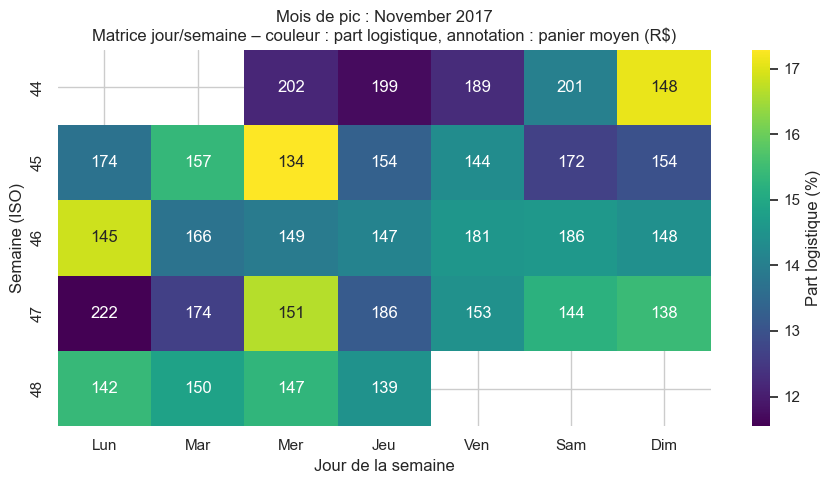

In [33]:
# 8 Variante 2 – Heatmap (matrice) : part logistique en couleur, panier moyen en annotation

# Préparation
daily_cal = daily.copy()
daily_cal["week"] = daily_cal["date"].dt.isocalendar().week.astype(int)
daily_cal["weekday"] = daily_cal["date"].dt.weekday  # 0 = lundi
daily_cal["day"] = daily_cal["date"].dt.day

pivot_share = daily_cal.pivot(index="week", columns="weekday", values="freight_share")
pivot_basket = daily_cal.pivot(index="week", columns="weekday", values="basket_mean")

weekday_labels = ["Lun", "Mar", "Mer", "Jeu", "Ven", "Sam", "Dim"]

# Affichage
fig, ax = plt.subplots(figsize=(9, 5))

sns.heatmap(
    pivot_share * 100,
    annot=pivot_basket.round(0),
    fmt=".0f",
    cmap="viridis",
    cbar_kws={"label": "Part logistique (%)"},
    ax=ax
)

ax.set_xlabel("Jour de la semaine")
ax.set_ylabel("Semaine (ISO)")
ax.set_title(
    f"Mois de pic : {month_name} {peak_year}\n"
    "Matrice jour/semaine – couleur : part logistique, annotation : panier moyen (R$)"
)
ax.set_xticklabels(weekday_labels, rotation=0)

plt.tight_layout()
plt.show()


In [ ]:
# Cette matrice montre, pour le mois de pic, comment se répartissent à la fois le panier moyen (chiffres) et la part logistique (couleurs) selon les semaines et les jours de la semaine.  
# On voit que les paniers moyens les plus élevés dépassent 200 R$ et se concentrent plutôt en début de mois, notamment autour du mercredi et du dimanche de la semaine 44.  
# La part logistique reste globalement comprise entre 12 % et 17 %, avec des couleurs plus “chaudes” sur certains jours isolés, ce qui signale des coûts de livraison plus lourds.  
# Les week-ends ne se distinguent pas clairement par une surchauffe logistique : les samedis et dimanches restent dans la même fourchette de part logistique que les autres jours.  
# En revanche, on observe quelques journées “à risque” où la part logistique est élevée alors que le panier moyen n’est pas particulièrement fort, par exemple certains mercredis ou jeudis.  
# Globalement, ce graphique suggère que la tension logistique pendant le mois de pic est assez diffuse sur l’ensemble des jours, sans pic extrême concentré sur un seul créneau, ce qui peut compliquer la planification des capacités.  
# Pour la plateforme, l’enjeu n’est donc pas seulement de gérer quelques jours “black friday”, mais plutôt un plateau de demande soutenue où la logistique doit rester maîtrisée tout au long du mois.  


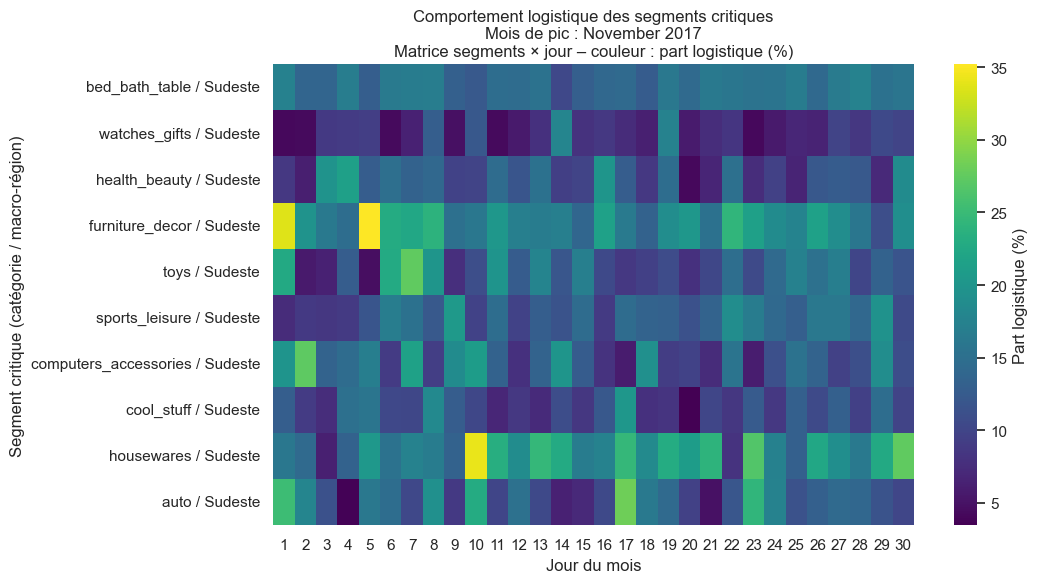

In [34]:
# 9 Mois de pic : comportement logistique des segments critiques (catégorie × macro-région) au jour le jour

# Préparation
# Re-définition des segments critiques (Top 10 sur l'ensemble de la période)
seg_full = (
    F_ACHATS
    .dropna(subset=["category_name", "macro_region"])
    .groupby(["category_name", "macro_region"], as_index=False)
    .agg(
        line_total_sum=("line_total", "sum")
    )
)
top_segments = (
    seg_full
    .sort_values("line_total_sum", ascending=False)
    .head(10)
)

# Filtre mois de pic déjà déterminé dans le graphique 8
mask_peak = (F_ACHATS["year"] == peak_year) & (F_ACHATS["month"] == peak_month)
df_peak = F_ACHATS.loc[mask_peak].copy()

df_peak_segments = df_peak.merge(
    top_segments[["category_name", "macro_region"]],
    on=["category_name", "macro_region"],
    how="inner"
)

seg_daily = (
    df_peak_segments
    .groupby(["date", "category_name", "macro_region"], as_index=False)
    .agg(
        line_total_sum=("line_total", "sum"),
        freight_sum=("freight_value", "sum")
    )
)
seg_daily["freight_share"] = seg_daily["freight_sum"] / seg_daily["line_total_sum"]
seg_daily["segment"] = seg_daily["category_name"] + " / " + seg_daily["macro_region"]
seg_daily["day"] = seg_daily["date"].dt.day

# ordre des segments (du plus important au moins important en CA)
seg_order = (
    seg_daily
    .groupby("segment")["line_total_sum"]
    .sum()
    .sort_values(ascending=False)
    .index
)

# matrice segments × jour (mois de pic)
pivot_seg = (
    seg_daily
    .pivot(index="segment", columns="day", values="freight_share")
    .loc[seg_order]
    .sort_index(axis=1)
)

# Affichage
fig, ax = plt.subplots(figsize=(11, 6))

sns.heatmap(
    pivot_seg * 100,
    cmap="viridis",
    cbar_kws={"label": "Part logistique (%)"},
    ax=ax,
    annot=False  # mettre True si tu veux annoter les % dans chaque case
)

ax.set_xlabel("Jour du mois")
ax.set_ylabel("Segment critique (catégorie / macro-région)")
ax.set_title(
    f"Comportement logistique des segments critiques\n"
    f"Mois de pic : {calendar.month_name[peak_month]} {peak_year}\n"
    "Matrice segments × jour – couleur : part logistique (%)"
)

plt.tight_layout()
plt.show()


In [ ]:
# Cette matrice montre, pour le mois de pic, comment la part logistique varie jour par jour sur les 10 segments critiques (catégorie × Sudeste).  
# On voit immédiatement que certains segments comme “furniture_decor / Sudeste” et “housewares / Sudeste” présentent plusieurs pics très élevés, dépassant ponctuellement les 30 % de part logistique.  
# À l’inverse, des segments plus “premium” comme “watches_gifts / Sudeste” ou “cool_stuff / Sudeste” restent dans une fourchette plus modérée, même si l’on observe quelques journées isolées plus sombres.  
# La variabilité intra-mois est forte : pour un même segment, la part logistique peut quasiment doubler selon le jour, ce qui traduit des tensions ponctuelles sur la chaîne de livraison (capacité, distance, promotions, etc.).  
# On remarque aussi que les premiers jours du mois concentrent plusieurs cases très claires sur les segments maison/déco, ce qui laisse penser à un démarrage de mois particulièrement coûteux pour ces catégories.  
# Globalement, ce graphique confirme que, même au sein des segments “Top 10” du Sudeste, tous les jours ne se valent pas : certains couples segment × jour génèrent un surcoût logistique important qu’il faudrait cibler dans les plans d’optimisation.  
# En pratique, la plateforme pourrait utiliser ce type de matrice pour identifier les “jours rouges” par segment et ajuster soit les politiques de livraison (seuils de franco, délais), soit le pilotage des campagnes marketing sur les périodes les plus coûteuses.


In [ ]:
#conlcusion

In [ ]:
# Cette analyse confirme d’abord que le business est fortement tiré par quelques catégories “stars” et par la région Sudeste, mais que tous ces segments n’ont pas le même profil logistique.  
# Les catégories vraiment “premium” comme watches_gifts ou cool_stuff combinent panier très élevé et part logistique plutôt contenue, ce qui en fait des moteurs de rentabilité plutôt que des zones de tension.  
# À l’inverse, des segments comme housewares, furniture_decor ou bed_bath_table affichent des paniers beaucoup plus faibles avec une part logistique élevée, surtout hors Sudeste, ce qui les rend structurellement fragiles.  
# Sur le plan géographique, le Sudeste reste la zone la plus efficiente : même si le panier moyen y est un peu plus bas, la part logistique y est minimale, alors que Norte et Nordeste cumulent coûts de livraison élevés et distances plus importantes.  
# Les délais limit sont globalement homogènes autour de 6–7 jours, ce qui laisse penser que la plateforme maintient ses promesses de préparation, mais parfois au prix d’un coût logistique nettement supérieur dans les régions éloignées.  
# Les segments critiques que l’on suit de près (Top 10 catégorie × région) ne sont donc pas tous “panier élevé + coût logistique élevé” : certains sont volumineux mais plutôt sains, d’autres cumulent faible panier, forte part logistique et volumes importants.  
# Les matrices jour/semaine du mois de pic montrent en plus que cette pression logistique est diffuse sur l’ensemble du mois, avec certains jours particulièrement coûteux pour les catégories maison/déco même au Sudeste.  
# Au final, l’hypothèse de départ n’est que partiellement vérifiée : oui, une partie des segments qui tirent le chiffre d’affaires subissent une forte pression logistique, mais d’autres, au contraire, amortissent bien les coûts de livraison et doivent être protégés, tandis que les segments “faible panier / forte logistique”, surtout dans Norte et Nordeste, devraient être au cœur des plans d’optimisation.  
